In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pomegranate import GeneralMixtureModel, NormalDistribution
import scipy.integrate as integrate
import sys
sys.path.insert(0,'./bin')
from pipeline_utils.pomegranate_parser import to_pomegranate

In [3]:
dataset = "somatosensory_converted_into_tpm"
dich_types = ["vrs", "3max", "geomean"]

In [4]:
df = pd.read_csv("{}.csv".format(dataset),index_col="gene_id")
thresholds = {x: pd.read_csv("{}/intermediate/{}/optimal_thresholds.csv".format(dataset, x), index_col="gene_id") for x in dich_types}
fitted_thresholds = pd.read_csv("{}/mathematica/fitted_distributions_thresholds.csv".format(dataset), index_col="gene_id")
fitted_distributions = pd.read_csv("{}/mathematica/mathematica_results.csv".format(dataset), index_col="gene_id")

In [5]:
def get_norm(arr):
    return {
        "weights": np.ones(len(arr)) / len(arr)
    }

In [6]:
fitted_distributions.loc[fitted_distributions.index.str.startswith("Pcdha")]

,distribution,antimode,thresholds
gene_id,,,
Pcdha1,"FrechetDistribution[1.1320561183335924, 0.2117...",NotMixture,"""""[13805]"
Pcdha10,"MixtureDistribution[{0.8874118117423982, 0.112...","{{{x -> 0.010925792177688333}, ""Mode""}, {{x ->...",0.3397657756570421
Pcdha11,"MixtureDistribution[{0.8090756114693685, 0.190...","{{{x -> 0.014498767680176243}, ""Mode""}, {{x ->...",0.3663592186296045
Pcdha12,"MixtureDistribution[{0.7086679601363048, 0.291...",{},NotFound
Pcdha2,"WeibullDistribution[0.777262314581022, 4.80774...",NotMixture,"""""[13809]"
Pcdha3,"MixtureDistribution[{0.8401440740559335, 0.159...","{{{x -> 0.04800833052192871}, ""Mode""}, {{x -> ...",0.5307706222656015
Pcdha4,"MixtureDistribution[{0.7792993186293271, 0.220...",{},NotFound
Pcdha4-g,"MixtureDistribution[{0.9629822852463807, 0.037...",{},NotFound
Pcdha5,"MixtureDistribution[{0.8656327929412689, 0.134...","{{{x -> 0.027588121661595244}, ""Mode""}, {{x ->...",0.44373057306255126


In [29]:
gene_id = "Piezo2"

In [30]:
model = to_pomegranate(fitted_distributions.loc[gene_id,"distribution"])
model

{
    "class" :"Distribution",
    "name" :"ExponentialDistribution",
    "parameters" :[
        0.039209442385216065
    ],
    "frozen" :false
}

In [31]:
def get_proba_for_range(model, a, b):
    return integrate.quad(lambda x: model.probability([x]), a, b)[0]

def get_proba_for_range_log(model, a, b):
    return integrate.quad(lambda x: model.probability([np.power(2,x)]), a, b)[0]

8.286859427682788
0
VRS ratio on: 0.16666666666666666
VRS 42.873090672459284
FM ratio on: 0.7598039215686274
FM 8.286859427682787
GTME ratio on: 0.9019607843137255
GTME 2.6866197271186794
no fitted


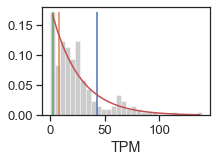

In [32]:
plt.figure(figsize=(3,2))
rug_kws = {"height": 0.95, "linewidth": 1.5}
sns.set(context="notebook", font_scale=1.2, style="ticks", font="Arial")
gene = df.loc[gene_id]
print(gene.quantile(0.975)/10)
(bins, edges) = np.histogram(gene, bins = 30)
p = sns.distplot(gene, kde=False, norm_hist=False, hist_kws=get_norm(gene), bins=edges, color="grey")
height = p.get_ylim()[1]
width = p.get_xlim()[1]
print((gene == 0).sum())
for x, label in zip(dich_types, ["VRS", "FM", "GTME"]):
    threshold = thresholds[x].loc[gene.name, "threshold"]
    print(label, "ratio on:", (gene >= threshold).sum() / len(gene))
    print(label, threshold)
    sns.distplot([threshold], kde=False, hist=False, rug=True, rug_kws=rug_kws, label=label)
try:
    threshold = fitted_thresholds.loc[gene.name, "threshold"]
    sns.distplot([threshold], kde=False, hist=False, rug=True, rug_kws=rug_kws, label="from distribution")
    print("antimode", threshold)
except:
    print("no fitted")
try:
    x = np.arange(0,width,0.1)
    # pdf = model.probability(x)
    y = [get_proba_for_range(model, a, b) for a, b in zip(edges[:-1], edges[1:])]
    plt.plot((edges[:-1] + edges[1:]) / 2, y, label="PDF (integration)",alpha=1.0)
    # plt.xlim([-1, 42])
except:
    print("no model")

# plt.legend(bbox_to_anchor=(0.80,-0.25))
# plt.legend()
plt.xlabel("TPM")
plt.show()



0.9952906785567799

no fitted


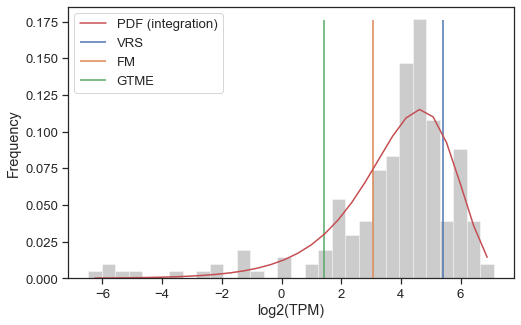

In [33]:
gene = df.loc[gene_id]
plt.figure(figsize=(8,5))
gene = np.log2(gene[gene > 0])
(bins, edges) = np.histogram(gene, bins = 30)
y = [get_proba_for_range(model, np.power(2,a), np.power(2,b)) for a, b in zip(edges[:-1], edges[1:])]
display(sum(y))
p = sns.distplot(gene, kde=False, hist_kws=get_norm(gene), bins = edges, color="grey")
height = p.get_ylim()[1]
xlim = p.get_xlim()
for x, label in zip(dich_types, ["VRS", "FM", "GTME"]):
    threshold = np.log2(thresholds[x].loc[gene.name, "threshold"])
#     plt.plot([threshold, threshold], [0, height], label=x)
    sns.distplot([threshold], kde=False, hist=False, rug=True, rug_kws=rug_kws, label=label)
try:
    threshold = np.log2(fitted_thresholds.loc[gene.name, "threshold"])
    # plt.plot([threshold, threshold], [0, height], label="from distribution")
    sns.distplot([threshold], kde=False, hist=False, rug=True, rug_kws=rug_kws, label="Fit. Distr.")
except:
    print("no fitted")
    
try:
    x = np.logspace(*xlim, base=2)
    # x = np.arange(2**-6,width,0.1)
    # print(x)
    pdf = model.probability(x)
    # print(pdf)
    # sns.lineplot(np.log2(x), pdf, label="PDF (unscaled)",alpha=0.5)
    # sns.lineplot(np.log2(x), pdf * height, label="PDF (scaled, as on slides)",alpha=0.5)

    sns.lineplot((edges[:-1] + edges[1:]) / 2, y, label="PDF (integration)", alpha=1.0, markers=True)
    # plt.ylim([0, height])
except:
    print("no model")

# plt.legend(bbox_to_anchor=(0.80,-0.25))
plt.legend()
plt.xlabel("log2(TPM)")
plt.ylabel("Frequency")
plt.show()

In [14]:
y = integrate.quad(lambda x: model.probability([np.power(2,x)]), edges[0], edges[1])

In [15]:
model.probability([np.power(2,-5.)])

array([0.29436409])

In [16]:
#%% Code so the same scripts can be used as notebooks and as part of a pipeline
try:
    if __IPYTHON__:
        import sys
        sys.path.insert(0,'./bin')
except:
    pass

from pipeline_utils.vrs_utils import get_vrs, grange
from scipy.stats.mstats import gmean


In [17]:
def _get_vrs(toy):
    threshold_range = grange(*np.nanquantile(toy,[0.025, 0.975]))
    values = [get_vrs(toy, x) for x in threshold_range]
    return threshold_range[np.nanargmin(values)]
    
def plot_toy(toy, canon="vrs", xlim=None):
    rug_kws = {"height": 0.95, "linewidth": 1.5}
    hist, bins = np.histogram(toy, bins=50) 
    
    vrs_threshold = _get_vrs(toy)
    if canon == "vrs":
        canonical_threshold = vrs_threshold
        
    upper = np.quantile(toy, 0.975)
    fm_threshold = upper / 10
    if canon == "fm":
        canonical_threshold = fm_threshold
        
    lower = np.quantile(toy, 0.025)
    gtme_threshold = gmean([upper, lower])
    if canon == "gtme":
        canonical_threshold = gtme_threshold
    
    left_bins = bins[:sum(bins < canonical_threshold)]
    right_bins = bins[-1-sum(bins > canonical_threshold):]
    sns.distplot(toy, bins=left_bins, kde=False)
    sns.distplot(toy, bins=right_bins, kde=False)
    sns.distplot([vrs_threshold], rug=True, kde=False, hist=False, rug_kws=rug_kws, label="VRS")
    sns.distplot([fm_threshold], rug=True, kde=False, hist=False, rug_kws=rug_kws, label="FM")
    sns.distplot([gtme_threshold], rug=True, kde=False, hist=False, rug_kws=rug_kws, label="GTME")
    sns.distplot([upper], rug=True, kde=False, hist=False, rug_kws=rug_kws, label="97.5th Percentile", color="black")
    sns.distplot([lower], rug=True, kde=False, hist=False, rug_kws=rug_kws, label="2.5th Percentile", color="grey")
    plt.legend()
    plt.xlim(xlim)
    plt.show()

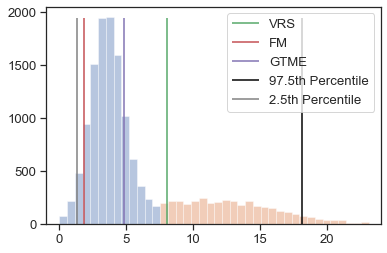

In [23]:
toy_left = np.random.normal(3.5,1.2,10000)
toy_right = np.random.normal(11,5,5000)
toy = np.concatenate([toy_left, toy_right])
toy = toy[(toy > 0)]
plot_toy(toy,"vrs",[-1,24])

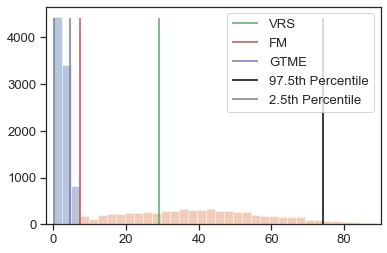

In [25]:
toy_left = np.random.normal(2,2.0,10000)
toy_right = np.random.normal(38,22,7000)
toy = np.concatenate([toy_left, toy_right])
toy = toy[(toy > 0)]
plot_toy(toy,"fm",[-2,90])

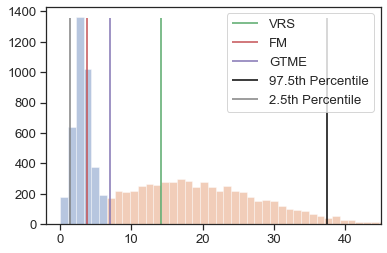

In [28]:
toy_left = np.random.normal(3,1.0,3000)
toy_right = np.random.normal(17,11,7000)
toy = np.concatenate([toy_left, toy_right])
toy = toy[(toy >= 0) & (toy < 60)]
plot_toy(toy,"gtme",[-2,45])

58.34871842506603

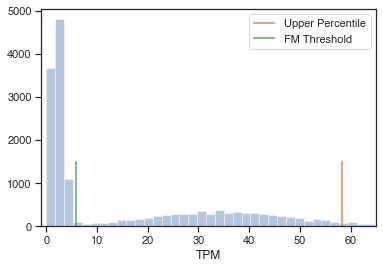

In [96]:
sns.distplot(toy, kde=False, bins=50)
top_three = np.quantile(toy[toy > 0], 0.975)#sorted(toy)[-3:]
display(top_three)
# for i, x in enumerate(top_three):
#     plt.plot([x,x],[0,1000],label=("Three Max" if i == 0 else None), color="red")
sns.distplot([top_three], kde=False, hist=False, rug=True, rug_kws=rug_kws, label="Upper Percentile")
sns.distplot([top_three / 10], kde=False, hist=False, rug=True, rug_kws=rug_kws, label="FM Threshold")
    

plt.xlim([-1,65])
# plt.legend(bbox_to_anchor=(0.75,-0.15))
plt.legend()
plt.xlabel("TPM")
plt.show()

In [116]:
toy_left = np.random.normal(1.0,0.6,3000)
toy_right = np.random.normal(17,11,7000)
toy = np.concatenate([toy_left, toy_right])
toy = toy[(toy >= 0) & (toy < 60)]
top = 2200

3.3063553310123774

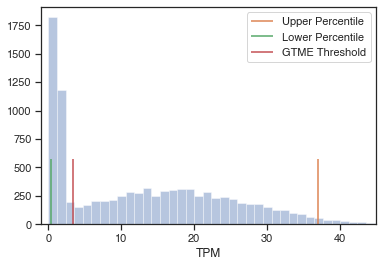

In [118]:
sns.distplot((toy), kde=False, bins=50)
top_three = np.quantile(toy[toy > 0], 0.975)
bottom_three = np.quantile(toy[toy > 0], 0.025)
sns.distplot([top_three], kde=False, hist=False, rug=True, rug_kws=rug_kws, label="Upper Percentile")
sns.distplot([bottom_three], kde=False, hist=False, rug=True, rug_kws=rug_kws, label="Lower Percentile")
    
threshold = gmean([(bottom_three), (top_three)])
display(threshold)
sns.distplot([threshold], kde=False, hist=False, rug=True, rug_kws=rug_kws, label="GTME Threshold")

plt.xlim([-1,45])
# plt.legend(bbox_to_anchor=(0.75,-0.15))
plt.legend()
plt.xlabel("TPM")
plt.show()

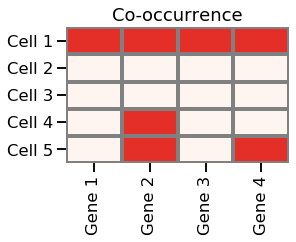

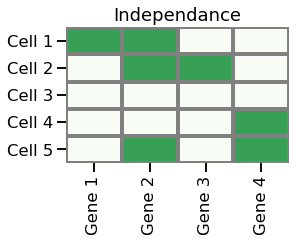

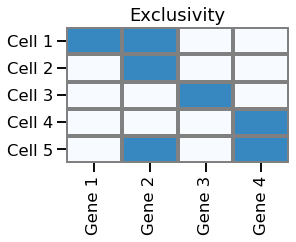

In [42]:
plt.figure(figsize=(4,2.5))
sns.heatmap(pd.DataFrame(
    [[1,1,1,1],
     [0,0,0,0],
     [0,0,0,0],
     [0,1,0,0],
     [0,1,0,1]],
    columns=["Gene {}".format(x) for x in range(1,5)],
    index=["Cell {}".format(x) for x in range(1,6)]
),linewidths=3.0,linecolor="grey", cbar=False, cmap="Reds", vmax=1.5, vmin=0)
plt.title("Co-occurrence")
plt.show()


plt.figure(figsize=(4,2.5))
sns.heatmap(pd.DataFrame(
    [[1,1,0,0],
     [0,1,1,0],
     [0,0,0,0],
     [0,0,0,1],
     [0,1,0,1]],
    columns=["Gene {}".format(x) for x in range(1,5)],
    index=["Cell {}".format(x) for x in range(1,6)]
),linewidths=3.0,linecolor="grey", cbar=False, cmap="Greens", vmax=1.5, vmin=0)
plt.title("Independance")
plt.show()



plt.figure(figsize=(4,2.5))
sns.heatmap(pd.DataFrame(
    [[1,1,0,0],
     [0,1,0,0],
     [0,0,1,0],
     [0,0,0,1],
     [0,1,0,1]],
    columns=["Gene {}".format(x) for x in range(1,5)],
    index=["Cell {}".format(x) for x in range(1,6)]
),linewidths=3.0,linecolor="grey", cbar=False, cmap="Blues", vmax=1.5, vmin=0)
plt.title("Exclusivity")
plt.show()


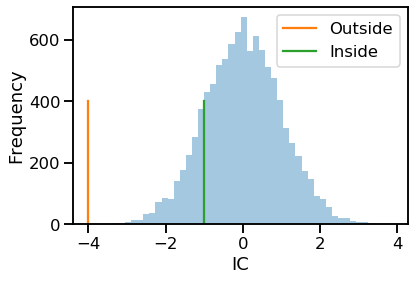

In [47]:
toy_ic = np.random.normal(0,1,10000)

sns.distplot(toy_ic, kde=False)
plt.plot([-4,-4],[0,400],label="Outside")
plt.plot([-1,-1],[0,400],label="Inside")
plt.legend()
plt.xlabel("IC")
plt.ylabel("Frequency")
plt.show()